In [6]:
from ngsolve import *
#from ngsolve.webgui import Draw
from netgen.occ import *
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def matvec_b(v):
    tmp1.data = v
    tmp2.data = b * tmp1
    return tmp2.FV().NumPy()


def matvec_c(v):
    tmp3.data = v
    tmp4.data = c.mat * tmp3
    return tmp4.FV().NumPy()

In [ ]:
def L2_Primal_Dual_L2IP(mesh):

    pv = mesh.vertices
    nv = len(pv)
    #Setup

    #Barycentric Refinement
    mesh.ngmesh.SplitPowellSabin()

    #for fine to coarse mapping
    fes_primal = Compress(L2(mesh, order=0, dirichlet="bottom|right|top|left"))

    L2_u = fes_primal.TrialFunction()

    #for mapping to dual
    fes_dual = Compress(H1(mesh, order=1, dirichlet="bottom|right|top|left"))

    H1_v = fes_dual.TestFunction()

    #L2 inner product of H1 and L2 basis function on barycentrically refined mesh
    L2_H1_L2IP = BilinearForm(trialspace=fes_primal, testspace=fes_dual) #fes_dual)
    L2_H1_L2IP += L2_u * H1_v * dx

    L2_H1_L2IP.Assemble()
    #print(L2_H1_L2IP.mat.shape)

    rows,cols,vals  = L2_H1_L2IP.mat.COO()

    mat = sp.sparse.csr_matrix((vals,(rows,cols)))

    # mapping to dual 

    data_length = mesh.ne * 7
    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for el in mesh.Elements():
        parent = mesh.ngmesh.MacroElementNr(el.nr)
        for v in el.vertices:
            ver = mesh.__getitem__(v)
            dofnr = fes_dual.GetDofNrs(ver)
            row_ind[j] = parent
            col_ind[j] = dofnr[0]
            data[j] = 1/len(ver.elements)
            j += 1

    dual_map = sp.sparse.csr_matrix((data,(row_ind,col_ind)))
    # mapping to coarse primal
    #L2 fine to coarse mapping

    data_length = mesh.ne
    data = np.zeros(data_length)
    row_ind = np.zeros(data_length, dtype=int)
    col_ind = np.zeros(data_length, dtype=int)

    j = 0

    for el in mesh.Elements():
        parent = mesh.ngmesh.MacroElementNr(el.nr)
        for dofnr in fes_primal.GetDofNrs(el):
            row_ind[j] = parent
            col_ind[j] = dofnr
            data[j] = 1
            j += 1

    primal_map = sp.sparse.csr_matrix((data,(row_ind,col_ind)))
    
    #TODO make sure this constellation of shapes, and what they represent make sense
    dual_L2IP = dual_map @ mat @ primal_map.T

    coo = dual_L2IP.tocoo(copy=True)

    NG_dual = la.SparseMatrixdouble.CreateFromCOO(coo.row,coo.col,coo.data, mesh.ne//6, mesh.ne//6)

    return NG_dual


# netgen_mesh = unit_square.GenerateMesh(maxh=1)

# mesh = Mesh(netgen_mesh)

# matrix = L2_Primal_Dual_L2IP(mesh)

# print(matrix.ToDense())

 0.416667 0.0833333
 0.0833333 0.416667



In [ ]:
#l is number of meshwidths, the n-th meshwidth is 1/(2^(n-1))
l = 6
meshwidths = np.ones(l) 
for h in range(l-1):
    meshwidths[h+1] = meshwidths[h]/2

print(meshwidths)
#order for which the elements corresponds to the whitney forms
low_order = 0

#amount of orders for the high-Order space
high_orders = 3 
#array storing the minimal Eigenvalue for given orders and meshwidth
minEV = np.zeros((high_orders,l))

#TODO remove low oder iteration

lowest_high_Order = low_order + 1
    #largest high order to test
highest_high_order = lowest_high_Order + high_orders

for i in range(lowest_high_Order, highest_high_order):
    print("polynomal order of low order space:", low_order, ", polynomal order of high order space:", i)
    for k in range(l):
        mw = meshwidths[k]
        print("h=",mw)
        #Draw(mesh)

        netgen_mesh =unit_square.GenerateMesh(maxh=mw)
        mesh=Mesh(netgen_mesh)

        netgen_dual = netgen_mesh.Copy()
        dual_mesh=Mesh(netgen_dual)

        #actual meshwidth
        elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
        mesh_h = [(2*vol)**(1/2) for vol in elvol]
        print("actual meshwidth range",min(mesh_h),max(mesh_h), "\n")

        #need to compress to remove DOFs of unrefined mesh after refinement
        H_h = Compress(L2(mesh, order = low_order, complex=False, dirichlet="bottom|right|top|left")) # main function space
        w_h = GridFunction(H_h) #define vector for matvec wrapper
        H_H = Compress(L2(mesh, order = i, complex=False, dirichlet="bottom|right|top|left")) # high order Function space for Riesz representative  

        print("# DoFs of low order space:", H_h.ndof, ", # DoFs of high order space:", H_H.ndof)

        #low order
        u_h = H_h.TrialFunction() # define the trial function
        v_h = H_h.TestFunction() # define the test function
        #High order
        u_H = H_H.TrialFunction() # define the trial function
        v_H= H_H.TestFunction() # define the test function

        a = BilinearForm(H_H, symmetric=True, symmetric_storage=False) # define the L2 inner product on the high order space
        a += u_H*v_H * dx 
        a.Assemble()

        #mass matrix with mixed basis functions
        a_mixed = BilinearForm(trialspace=H_h, testspace=H_H)
        a_mixed += u_h*v_H*dx
        a_mixed.Assemble()

        m_dual = L2_Primal_Dual_L2IP(dual_mesh)

        #compute inverses 
        a_inv = a.mat.Inverse(freedofs=H_H.FreeDofs())

        #create Matrices for GEV problem

        #c is the low order galerkin matrix
        c = BilinearForm(H_h, symmetric=True, symmetric_storage=False)
        c += u_h*v_h * dx 

        c.Assemble()

        m_dual_inv = m_dual.Inverse(freedofs=H_h.FreeDofs()) 

        # b is the Matrix that lets us compute the norm of the Riesz representative
        b = c.mat.T @ m_dual_inv.T @ a_mixed.mat.T @ a_inv @ a_mixed.mat @ m_dual_inv @ c.mat

        tmp1 = w_h.vec.CreateVector()
        tmp2 = w_h.vec.CreateVector()

        tmp3 = w_h.vec.CreateVector()
        tmp4 = w_h.vec.CreateVector()

        B = sp.sparse.linalg.LinearOperator((b.height,b.width), matvec_b)
        C = sp.sparse.linalg.LinearOperator((c.mat.height,c.mat.width), matvec_c)            

        #The matrices Involved are Symmetric, so the symmetric solver is used
        #look for largest Eigenvalue of Bx = λCx, since ARPACK is more efficient for large EV's
        lam = sp.sparse.linalg.eigsh(B, k=1, M=C, which='LM', return_eigenvectors=False)
        print(lam)
        #if FEM space is complex need to take absolut value (the EV's have no imaginary part, but are still datatype complex)        
        #lam = np.abs(lam)
        #1/λ is the smallest EV of Cx = λBx
        minEV[i-lowest_high_Order,k] = 1/lam[0]

        print("\n")

print(minEV)

[1.      0.5     0.25    0.125   0.0625  0.03125]
polynomal order of low order space: 0 , polynomal order of high order space: 1
h= 1.0
actual meshwidth range 0.999999999999998 0.9999999999999981 

# DoFs of low order space: 2 , # DoFs of high order space: 6
[2.25]


h= 0.5
actual meshwidth range 0.499999999999999 0.7071067811865461 

# DoFs of low order space: 6 , # DoFs of high order space: 18
[5.3922112]


h= 0.25
actual meshwidth range 0.1854300870971452 0.3067363989577544 

# DoFs of low order space: 34 , # DoFs of high order space: 102
[8.03284666]


h= 0.125
actual meshwidth range 0.0851139651875047 0.1516226278076589 

# DoFs of low order space: 144 , # DoFs of high order space: 432
[8.67646439]


h= 0.0625
actual meshwidth range 0.043561562067754404 0.07502712695231538 

# DoFs of low order space: 616 , # DoFs of high order space: 1848
[8.80926708]


h= 0.03125
actual meshwidth range 0.020940423940470757 0.03897166452501391 

# DoFs of low order space: 2400 , # DoFs of high or

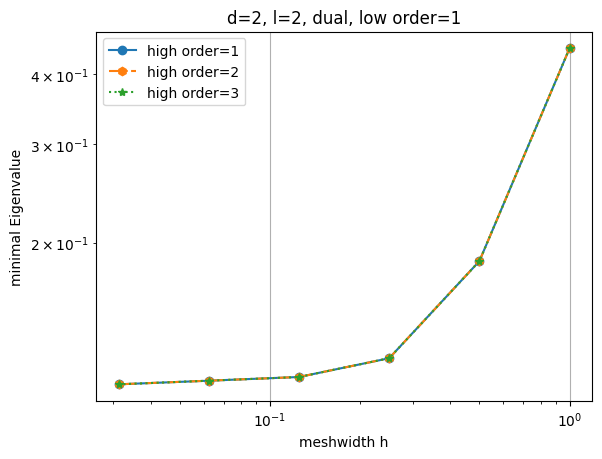

In [9]:
symbols = ['o-','h-.','*:','+-']

#minimal Ev

fig, ax = plt.subplots()
plt.grid(visible=True)
plt.title(label="d=2, l=2, dual, low order=%i" %1)
plt.xlabel('meshwidth h')
plt.ylabel('minimal Eigenvalue')

lowest_high_Order = low_order + 1
highest_high_order = lowest_high_Order + high_orders
for i in range(lowest_high_Order,highest_high_order):
    plt.loglog(meshwidths,minEV[i-lowest_high_Order,:], symbols[i-lowest_high_Order], label="high order=%i"%i)

plt.legend()

plt.savefig("d2l2_dual_BND.pdf")

plt.show()
